# Analyzing a Discrete Heart Rate Signal Using Python – Part 1

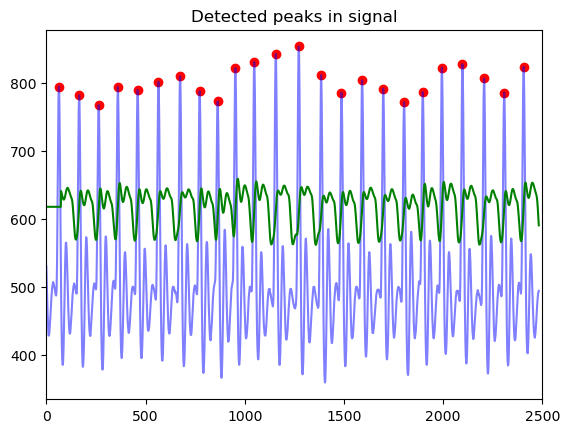

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

dataset = pd.read_csv("data.csv")

#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 100 #The example dataset was recorded at 100Hz

mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean() #Calculate moving average
#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.hart))
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['hart_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns

for datapoint in dataset.hart:
    rollingmean = dataset.hart_rollingmean[listpos] #Get local mean
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1
    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.hart[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

plt.title("Detected peaks in signal")
plt.xlim(0,2500)
plt.plot(dataset.hart, alpha=0.5, color='blue') #Plot semi-transparent HR
plt.plot(mov_avg, color ='green') #Plot moving average
plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
plt.show()
#np.savetxt("peaklist.csv", peaklist, delimiter=",")
np.savetxt("peaklist.csv", peaklist)

In [2]:
peaklist

[63,
 165,
 264,
 360,
 460,
 565,
 674,
 773,
 863,
 953,
 1048,
 1156,
 1272,
 1385,
 1487,
 1592,
 1698,
 1803,
 1897,
 1994,
 2097,
 2206,
 2308,
 2406]

Calculating heart rate
We know the position of each peak in time, so calculating the average ‘beats per minute’ (BPM) measure over this signal is straightforward. Just calculate the distance between the peaks, take the average and convert to a per minute value, like so:

In [3]:
RR_list = []
cnt = 0

while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1
np.savetxt("RRlist.csv", RR_list, delimiter=",")
    
bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print ("Average Heart Beat is: %.01f" %bpm) #Round off to 1 decimal and print

Average Heart Beat is: 58.9


Also update the plot method to show the BPM in the legend:

In [4]:
RR_list

[1020.0,
 990.0,
 960.0,
 1000.0,
 1050.0,
 1090.0,
 990.0,
 900.0,
 900.0,
 950.0,
 1080.0,
 1160.0,
 1130.0,
 1020.0,
 1050.0,
 1060.0,
 1050.0,
 940.0,
 970.0,
 1030.0,
 1090.0,
 1020.0,
 980.0]

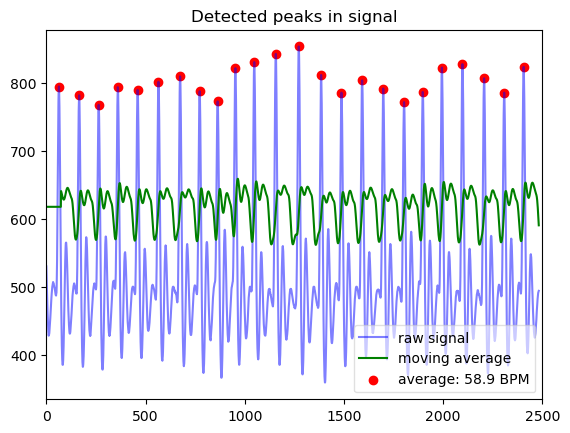

In [5]:
plt.title("Detected peaks in signal")
plt.xlim(0,2500)
plt.plot(dataset.hart, alpha=0.5, color='blue', label="raw signal") #Plot semi-transparent HR
plt.plot(mov_avg, color ='green', label="moving average") #Plot moving average
plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %bpm) #Plot detected peaks
plt.legend(loc=4, framealpha=0.6)
plt.show()

Rounding up
Finally let’s tidy up our code and put it in callable functions. This will make our life much easier in the next part, and our code much more organized and re-usable. Note that probably the tidy thing to do is to make the functions part of a Class, but to keep the tutorial accessible also to those less experienced in Python (and perhaps not familiar or confident with classes), I’ve chosen to omit this from all code in this tutorial series.
Let’s put the BPM value and the lists we calculate in a dictionary that we can call, and can append with the measures we will calculate in part 2. Also let’s write a wrapper function process() so that we can call our analysis with as little code as possible:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

measures = {}

def get_data(filename):
    dataset = pd.read_csv(filename)
    return dataset

def rolmean(dataset, hrw, fs):
    mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean()
    avg_hr = (np.mean(dataset.hart))
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    mov_avg = [x*1.2 for x in mov_avg]
    dataset['hart_rollingmean'] = mov_avg

def detect_peaks(dataset):
    window = []
    peaklist = []
    listpos = 0
    for datapoint in dataset.hart:
        rollingmean = dataset.hart_rollingmean[listpos]
        if (datapoint < rollingmean) and (len(window) < 1):
            listpos += 1
        elif (datapoint > rollingmean):
            window.append(datapoint)
            listpos += 1
        else:
            maximum = max(window)
            beatposition = listpos - len(window) + (window.index(max(window)))
            peaklist.append(beatposition)
            window = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.hart[x] for x in peaklist]

def calc_RR(dataset, fs):
    RR_list = []
    peaklist = measures['peaklist']
    cnt = 0
    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt])
        ms_dist = ((RR_interval / fs) * 1000.0)
        RR_list.append(ms_dist)
        cnt += 1
    measures['RR_list'] = RR_list

def calc_bpm():
    RR_list = measures['RR_list']
    measures['bpm'] = 60000 / np.mean(RR_list)

def plotter(dataset, title):
    peaklist = measures['peaklist']
    ybeat = measures['ybeat']
    plt.title(title)
    plt.plot(dataset.hart, alpha=0.5, color='blue', label="raw signal")
    plt.plot(dataset.hart_rollingmean, color ='green', label="moving average")
    plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %measures['bpm'])
    plt.legend(loc=4, framealpha=0.6)
    plt.show()

def process(dataset, hrw, fs): #Remember; hrw was the one-sided window size (we used 0.75) and fs was the sample rate (file is recorded at 100Hz)
    rolmean(dataset, hrw, fs)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_bpm()
    plotter(dataset, "My Heartbeat Plot")
